Time series analysis using seasonal ARIMA model to predict the crime counts in Chicago per day.
We will analyze features of a time series data set, and then see if we can use mathematical models to forecast into the future. We’ll also see how we can split our original time series data set to evaluate how well our model predicts the future

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from pyspark.sql.functions import isnan, when, count, col
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from datetime import datetime
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from numpy import exp
from scipy.special import factorial


# import plotly.plotly as py
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# import plotly.offline as offline
# from plotly.offline import plot
from pyspark.mllib.stat import Statistics

# import plotly.plotly as py
# import plotly.graph_objs as go
import pandas as pd
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)


Reading the Chicago Crime data

In [4]:
pandas_df = pd.read_csv("/dbfs/FileStore/tables/Crimes___2001_to_present-9be1b.csv", header='infer')
crimes = pd.DataFrame(pandas_df)

In [5]:
crimes.head()

Out[ 35 ]: 
 ID Case Number Date Block IUCR \
0 10000092 HY189866 2015-03-18 19:44:00 047XX W OHIO ST 041A 
1 10000094 HY190059 2015-03-18 23:00:00 066XX S MARSHFIELD AVE 4625 
2 10000095 HY190052 2015-03-18 22:45:00 044XX S LAKE PARK AVE 0486 
3 10000096 HY190054 2015-03-18 22:30:00 051XX S MICHIGAN AVE 0460 
4 10000097 HY189976 2015-03-18 21:00:00 047XX W ADAMS ST 031A 

 Primary Type Description Location Description Arrest \
0 BATTERY AGGRAVATED: HANDGUN STREET False 
1 OTHER OFFENSE PAROLE VIOLATION STREET True 
2 BATTERY DOMESTIC BATTERY SIMPLE APARTMENT False 
3 BATTERY SIMPLE APARTMENT False 
4 ROBBERY ARMED: HANDGUN SIDEWALK False 

 Domestic ... Community Area FBI Code X Coordinate \
0 False ... 25.0 04B 1144606.0 
1 False ... 67.0 26 1166468.0 
2 True ... 39.0 08B 1185075.0 
3 False ... 40.0 08B 1178033.0 
4 False ... 25.0 03 1144920.0 

 Y Coordinate Year Updated On Latitude Longitude \
0 1903566.0 2015 02/10/2018 03:50:01 PM 41.891399 -87.744385 
1 1860715.0 2015 02/10/2018 03:50:01 PM 41.773372 -87.665319 
2 1875622.0 2015 02/10/2018 03:50:01 PM 41.813861 -87.596643 
3 1870804.0 2015 02/10/2018 03:50:01 PM 41.800802 -87.622619 
4 1898709.0 2015 02/10/2018 03:50:01 PM 41.878065 -87.743354 

 Location new_date_column 
0 (41.891398861, -87.744384567) 2015-03-18 
1 (41.773371528, -87.665319468) 2015-03-18 
2 (41.81386068, -87.596642837) 2015-03-18 
3 (41.800802415, -87.622619343) 2015-03-18 
4 (41.878064761, -87.743354013) 2015-03-18 

[5 rows x 23 columns]

Data Preprocessing
This step includes removing columns we do not need, check missing values, aggregate crime counts by date and so on.

In [7]:
crimes.Date = pd.to_datetime(crimes.Date)
crimes.Date
# %I:%M:%S %p

Out[ 38 ]: 
0 2015-03-18 19:44:00
1 2015-03-18 23:00:00
2 2015-03-18 22:45:00
3 2015-03-18 22:30:00
4 2015-03-18 21:00:00
5 2015-03-18 22:00:00
6 2015-03-18 23:00:00
7 2015-03-18 21:35:00
8 2015-03-18 22:09:00
9 2015-03-18 21:25:00
10 2015-03-18 21:30:00
11 2015-03-15 16:10:00
12 2015-03-18 21:14:00
13 2015-03-18 22:50:00
14 2015-03-18 22:31:00
15 2015-03-18 12:55:00
16 2015-03-18 20:00:00
17 2015-03-18 21:00:00
18 2015-03-18 22:56:00
19 2015-03-18 22:45:00
20 2015-03-18 22:00:00
21 2014-09-01 08:00:00
22 2015-03-18 23:55:00
23 2015-03-18 23:40:00
24 2015-03-18 21:44:00
25 2015-03-18 23:30:00
26 2015-03-18 22:45:00
27 2015-03-18 22:33:00
28 2015-03-19 01:20:00
29 2015-03-18 21:59:00
 ... 
6657384 2018-06-23 13:00:00
6657385 2018-07-19 21:00:00
6657386 2017-10-02 19:00:00
6657387 2017-11-01 00:01:00
6657388 2018-07-06 00:01:00
6657389 2017-01-01 00:01:00
6657390 2018-07-03 19:00:00
6657391 2018-07-01 18:00:00
6657392 2018-05-23 09:00:00
6657393 2018-07-11 09:00:00
6657394 2018-07-12 00:51:00
6657395 2018-07-09 12:00:00
6657396 2018-07-10 01:00:00
6657397 2018-07-11 19:46:00
6657398 2018-07-13 18:12:00
6657399 2018-07-06 19:00:00
6657400 2018-07-18 09:00:00
6657401 2018-07-16 06:20:00
6657402 2018-07-10 01:00:00
6657403 2016-08-01 09:00:00
6657404 2016-07-10 19:00:00
6657405 2018-07-18 13:08:00
6657406 2018-07-19 17:00:00
6657407 2018-07-13 09:00:00
6657408 2018-07-15 08:30:00
6657409 2018-07-05 02:30:00
6657410 2018-07-10 00:01:00
6657411 2018-07-18 21:45:00
6657412 2018-07-19 02:00:00
6657413 2018-07-19 23:40:00
Name: Date, dtype: datetime64[ns]

In [8]:
# crimes['new_date_column'] = crimes['Date'].dt.date
# crimes['new_date_column']

Out[ 17 ]: 
0 2015-03-18
1 2015-03-18
2 2015-03-18
3 2015-03-18
4 2015-03-18
5 2015-03-18
6 2015-03-18
7 2015-03-18
8 2015-03-18
9 2015-03-18
10 2015-03-18
11 2015-03-15
12 2015-03-18
13 2015-03-18
14 2015-03-18
15 2015-03-18
16 2015-03-18
17 2015-03-18
18 2015-03-18
19 2015-03-18
20 2015-03-18
21 2014-09-01
22 2015-03-18
23 2015-03-18
24 2015-03-18
25 2015-03-18
26 2015-03-18
27 2015-03-18
28 2015-03-19
29 2015-03-18
 ... 
6657384 2018-06-23
6657385 2018-07-19
6657386 2017-10-02
6657387 2017-11-01
6657388 2018-07-06
6657389 2017-01-01
6657390 2018-07-03
6657391 2018-07-01
6657392 2018-05-23
6657393 2018-07-11
6657394 2018-07-12
6657395 2018-07-09
6657396 2018-07-10
6657397 2018-07-11
6657398 2018-07-13
6657399 2018-07-06
6657400 2018-07-18
6657401 2018-07-16
6657402 2018-07-10
6657403 2016-08-01
6657404 2016-07-10
6657405 2018-07-18
6657406 2018-07-19
6657407 2018-07-13
6657408 2018-07-15
6657409 2018-07-05
6657410 2018-07-10
6657411 2018-07-18
6657412 2018-07-19
6657413 2018-07-19
Name: new_date_column, dtype: object

In [9]:
type(crimes.new_date_column)

Out[ 39 ]: pandas.core.series.Series

In [10]:
# crime_df = crimes.groupby('Date')['Sales'].sum().reset_index()

# crime_sample=crimes.groupby(['Date']).sum()
# crime_sample.head()

crime_per_date=crimes.groupby('new_date_column')['ID'].count().reset_index()
crime_per_date.head()




Out[ 40 ]: 
 new_date_column ID
0 2001-01-01 1814
1 2001-01-02 1143
2 2001-01-03 1151
3 2001-01-04 1166
4 2001-01-05 1267

Check for null values and remove any missing values

In [12]:
crime_per_date.isnull().sum()
# crime_per_date.dtypes
# crime_per_date=crimes.groupBy('Date').orderBy('Date', ascending=True)
# crime_per_date = crime_per_date.set_index(pd.DatetimeIndex(crime_per_date['new_date']))
# display(crime_per_date.select('*'))


Out[ 106 ]: 
ID 0
dtype: int64

In [13]:
pd.to_datetime(pd.Series(crime_per_date['new_date_column']))


Out[ 43 ]: 
0 2001-01-01
1 2001-01-02
2 2001-01-03
3 2001-01-04
4 2001-01-05
5 2001-01-06
6 2001-01-07
7 2001-01-08
8 2001-01-09
9 2001-01-10
10 2001-01-11
11 2001-01-12
12 2001-01-13
13 2001-01-14
14 2001-01-15
15 2001-01-16
16 2001-01-17
17 2001-01-18
18 2001-01-19
19 2001-01-20
20 2001-01-21
21 2001-01-22
22 2001-01-23
23 2001-01-24
24 2001-01-25
25 2001-01-26
26 2001-01-27
27 2001-01-28
28 2001-01-29
29 2001-01-30
 ... 
6379 2018-06-20
6380 2018-06-21
6381 2018-06-22
6382 2018-06-23
6383 2018-06-24
6384 2018-06-25
6385 2018-06-26
6386 2018-06-27
6387 2018-06-28
6388 2018-06-29
6389 2018-06-30
6390 2018-07-01
6391 2018-07-02
6392 2018-07-03
6393 2018-07-04
6394 2018-07-05
6395 2018-07-06
6396 2018-07-07
6397 2018-07-08
6398 2018-07-09
6399 2018-07-10
6400 2018-07-11
6401 2018-07-12
6402 2018-07-13
6403 2018-07-14
6404 2018-07-15
6405 2018-07-16
6406 2018-07-17
6407 2018-07-18
6408 2018-07-19
Name: new_date_column, dtype: datetime64[ns]

Converting the String date column to datetime column

In [15]:
# pd.to_datetime(pd.Series(['05/23/2005']))
crime_per_date['new_date_column'] = pd.to_datetime(crime_per_date['new_date_column'])
# type(crime_per_date)

In [16]:
# crime_per_date = crime_per_date.set_index('new_date_column')
crime_per_date

Out[ 53 ]: 
 ID
new_date_column 
2001-01-01 1814
2001-01-02 1143
2001-01-03 1151
2001-01-04 1166
2001-01-05 1267
2001-01-06 1290
2001-01-07 1104
2001-01-08 1157
2001-01-09 1184
2001-01-10 1237
2001-01-11 1227
2001-01-12 1353
2001-01-13 1310
2001-01-14 1118
2001-01-15 1312
2001-01-16 1251
2001-01-17 1288
2001-01-18 1278
2001-01-19 1214
2001-01-20 1256
2001-01-21 1105
2001-01-22 1180
2001-01-23 1250
2001-01-24 1101
2001-01-25 1183
2001-01-26 1296
2001-01-27 1214
2001-01-28 1076
2001-01-29 1172
2001-01-30 1211
... ...
2018-06-20 861
2018-06-21 640
2018-06-22 705
2018-06-23 827
2018-06-24 859
2018-06-25 838
2018-06-26 779
2018-06-27 802
2018-06-28 797
2018-06-29 767
2018-06-30 840
2018-07-01 853
2018-07-02 835
2018-07-03 785
2018-07-04 808
2018-07-05 800
2018-07-06 851
2018-07-07 795
2018-07-08 802
2018-07-09 769
2018-07-10 781
2018-07-11 713
2018-07-12 768
2018-07-13 796
2018-07-14 764
2018-07-15 758
2018-07-16 725
2018-07-17 701
2018-07-18 772
2018-07-19 720

[6409 rows x 1 columns]

Quick look at number of crimes occurred in 2017

In [18]:
crime_per_date['2017':]

Out[ 55 ]: 
 ID
new_date_column 
2017-01-01 1091
2017-01-02 610
2017-01-03 716
2017-01-04 611
2017-01-05 610
2017-01-06 596
2017-01-07 617
2017-01-08 589
2017-01-09 707
2017-01-10 703
2017-01-11 658
2017-01-12 643
2017-01-13 798
2017-01-14 682
2017-01-15 655
2017-01-16 651
2017-01-17 701
2017-01-18 705
2017-01-19 735
2017-01-20 783
2017-01-21 787
2017-01-22 741
2017-01-23 788
2017-01-24 732
2017-01-25 749
2017-01-26 672
2017-01-27 781
2017-01-28 728
2017-01-29 633
2017-01-30 754
... ...
2018-06-20 861
2018-06-21 640
2018-06-22 705
2018-06-23 827
2018-06-24 859
2018-06-25 838
2018-06-26 779
2018-06-27 802
2018-06-28 797
2018-06-29 767
2018-06-30 840
2018-07-01 853
2018-07-02 835
2018-07-03 785
2018-07-04 808
2018-07-05 800
2018-07-06 851
2018-07-07 795
2018-07-08 802
2018-07-09 769
2018-07-10 781
2018-07-11 713
2018-07-12 768
2018-07-13 796
2018-07-14 764
2018-07-15 758
2018-07-16 725
2018-07-17 701
2018-07-18 772
2018-07-19 720

[565 rows x 1 columns]

Visualizing Chicago crime time series data

There is a downwardand seasonal trend in the number of crimes happening over the years from 2001 to 2018, meaning crime rate is declining at a steady rate

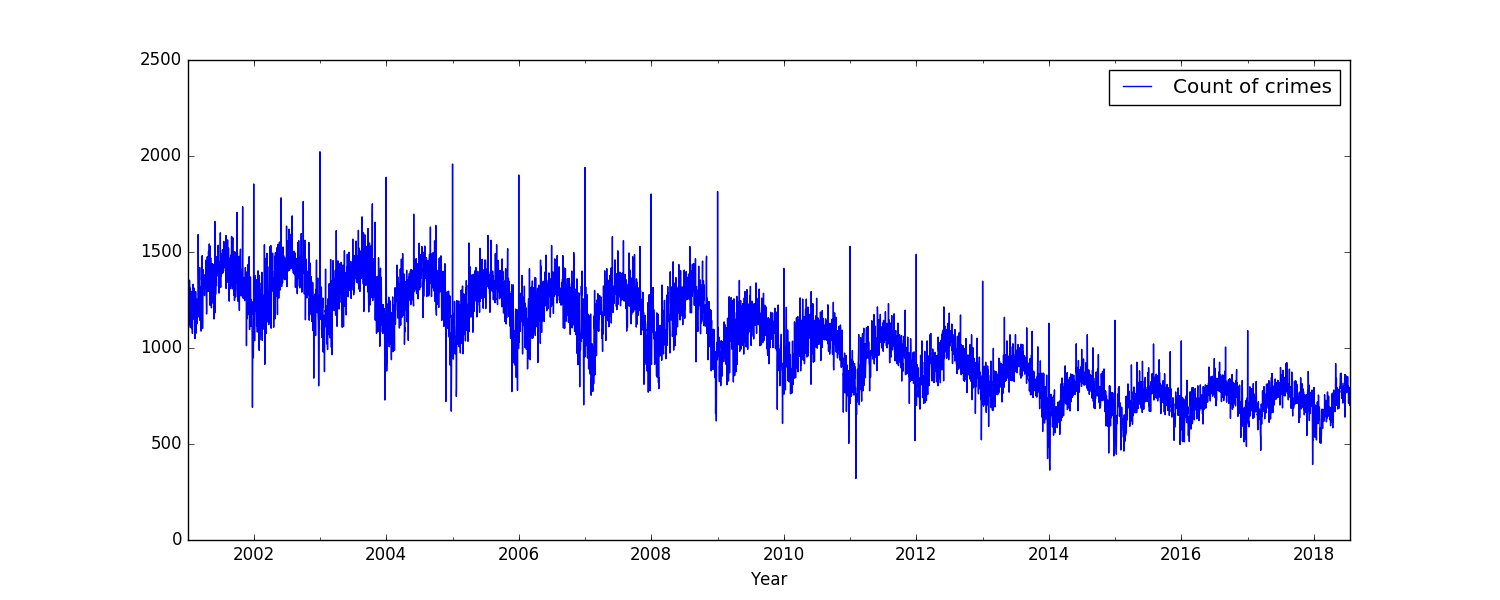

In [20]:
crime_per_date.plot(figsize=(15, 6))
plt.show()
plt.xlabel("Year")
plt.legend(['Count of crimes'])
display()

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

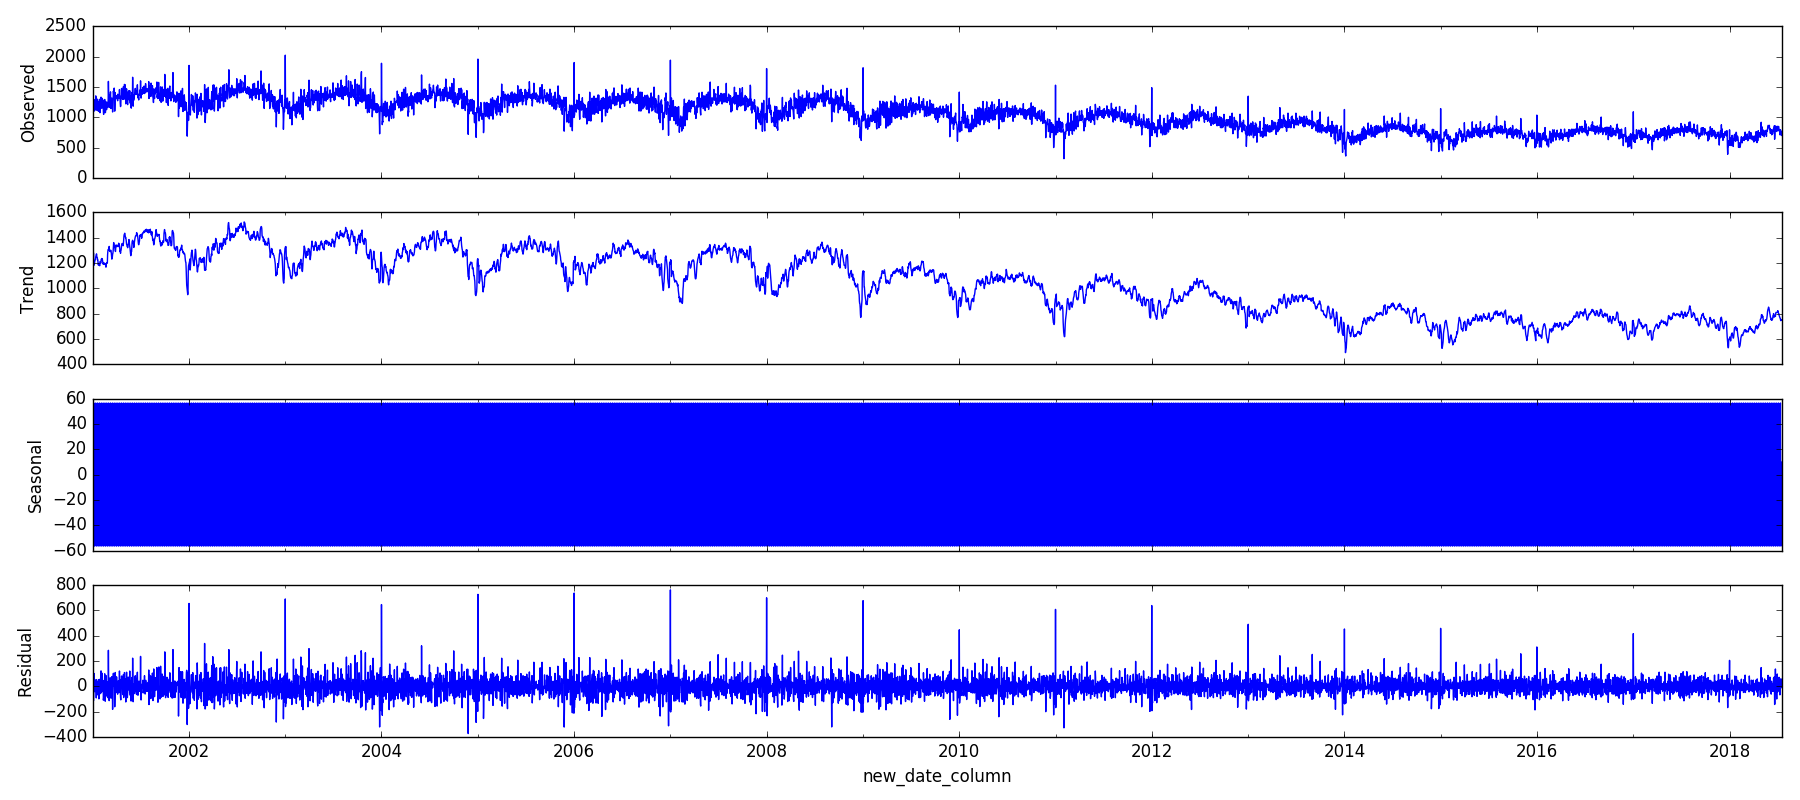

In [22]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(crime_per_date, model='additive')
fig = decomposition.plot()
plt.show()
display()

Time series forecasting with ARIMA.
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data

In [24]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)

This step is parameter Selection for our Chicago crime ARIMA Time Series Model. p,d,q parameters should be selected such that AIC is lowest for the combination

In [26]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(crime_per_date,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False, fit_kw=dict(method='css'))
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/databricks/python/local/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
/databricks/python/local/lib/python2.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:107587.736568
/databricks/python/local/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:99943.2053796
/databricks/python/local/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:80973.8994684
/databricks/python/local/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:78515.0407472
/databricks/python/local/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:80969.7540507
/databricks/python/local/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:78675.9597399
/databricks/python/local/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:79239.4820321
/databricks/python/local/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:78496.9142864
/databricks/python/local/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:99822.4965167
/databricks/python/local/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:94190.2288054
/databricks/python/local/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:80405.6021656
/databricks/python/local/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:77584.6999487
/databricks/python/local/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:80399.9533619
/databricks/python/local/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
/databricks/python/local/l

The above output suggests that SARIMAX(1, 0, 1)x(1, 1, 0, 12) yields the lowest AIC value of 757783.3. Therefore we should consider this to be optimal option.

In [28]:
results.aic

Out[ 75 ]: 75783.30631710844

Fitting the ARIMA model

In [30]:
mod = sm.tsa.statespace.SARIMAX(crime_per_date,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

/databricks/python/local/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
 % freq, ValueWarning)
==============================================================================
 coef std err z P>|z| [0.025 0.975]
------------------------------------------------------------------------------
ar.L1 0.3646 0.032 11.385 0.000 0.302 0.427
ma.L1 -0.0178 0.034 -0.528 0.598 -0.084 0.048
ar.S.L12 -0.5114 0.007 -78.450 0.000 -0.524 -0.499
sigma2 1.261e+04 119.492 105.540 0.000 1.24e+04 1.28e+04
==============================================================================

Running model diagnostics to investigate any unusual behavior and get statistics. Our model diagnostics suggests that the model residuals are normally distributed

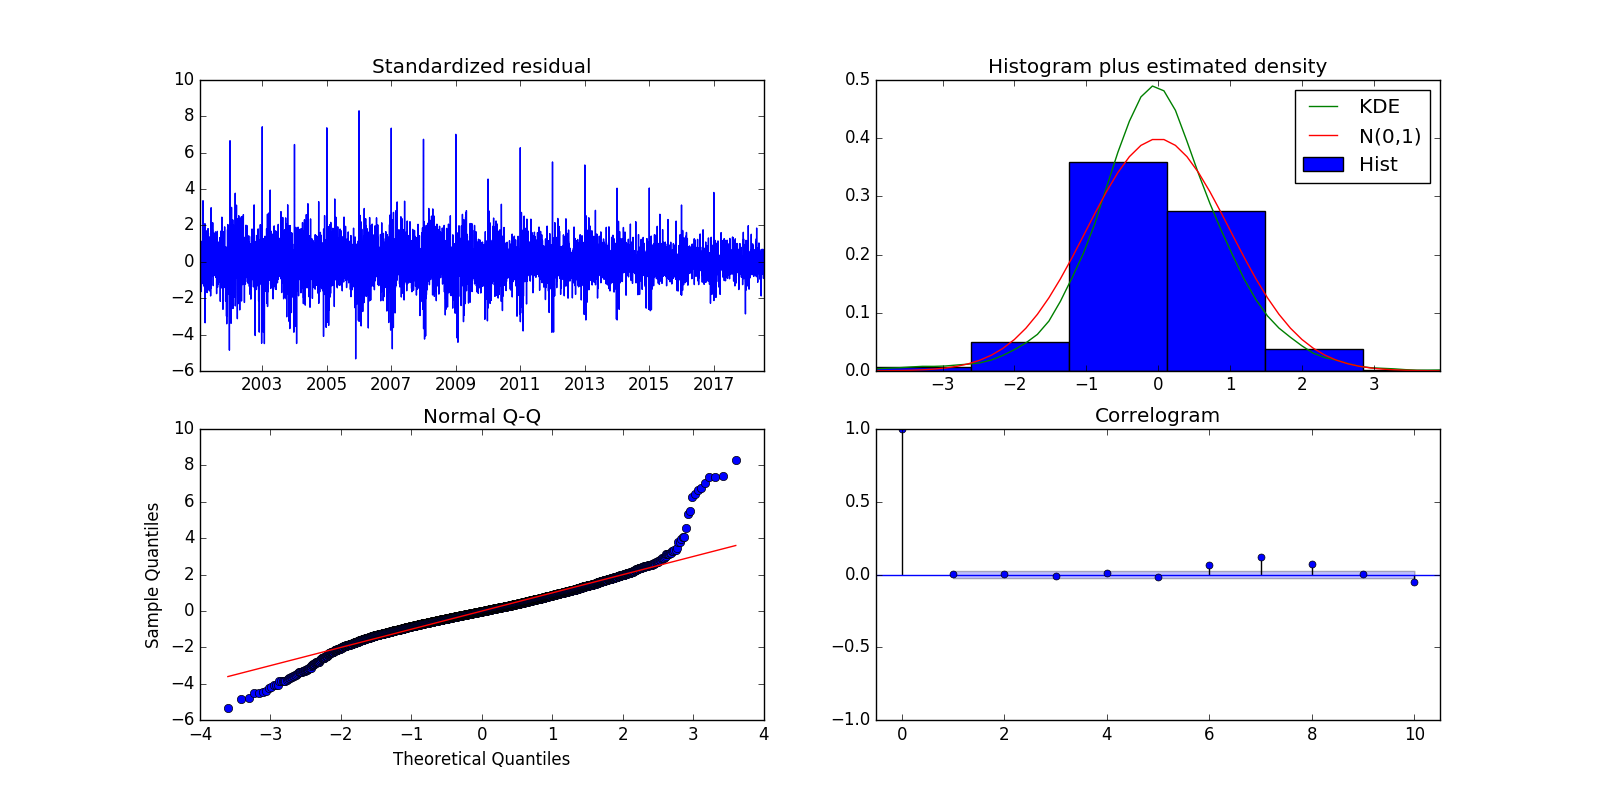

In [32]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()
display()

Validate forecasts
To help us understand the accuracy of our forecasts, we compare predicted count of crime to actual crime count of the time series, and we set forecasts to start at 2015–01–01 to the end of the data.

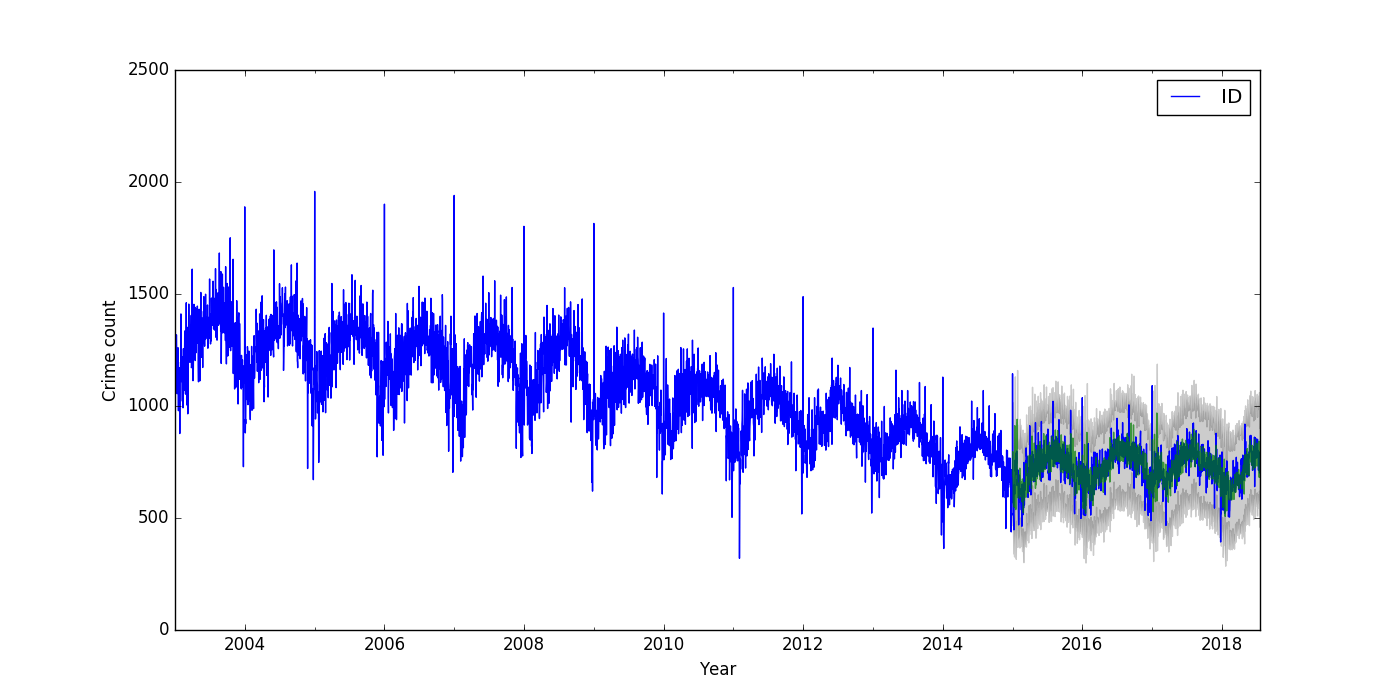

In [34]:
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = crime_per_date['2003':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Year')
ax.set_ylabel('Crime count')
# plt.legend(['Count of crimes'])
plt.show()
display()

The line plot is showing the observed values compared to the rolling forecast predictions. The values show a downward trend in the no of crimes happening which starts from the beginning of the year and captured the seasonality toward the end of the year.

In [36]:
y_forecasted = pred.predicted_mean
y_truth = crime_per_date['2015-01-02':]
mse = np.mean((y_forecasted - y_truth)**2)
# mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(mse))

The Mean Squared Error of our forecasts is 2015-01-01 00:00:00 NaN
2015-01-02 00:00:00 NaN
2015-01-03 00:00:00 NaN
2015-01-04 00:00:00 NaN
2015-01-05 00:00:00 NaN
2015-01-06 00:00:00 NaN
2015-01-07 00:00:00 NaN
2015-01-08 00:00:00 NaN
2015-01-09 00:00:00 NaN
2015-01-10 00:00:00 NaN
2015-01-11 00:00:00 NaN
2015-01-12 00:00:00 NaN
2015-01-13 00:00:00 NaN
2015-01-14 00:00:00 NaN
2015-01-15 00:00:00 NaN
2015-01-16 00:00:00 NaN
2015-01-17 00:00:00 NaN
2015-01-18 00:00:00 NaN
2015-01-19 00:00:00 NaN
2015-01-20 00:00:00 NaN
2015-01-21 00:00:00 NaN
2015-01-22 00:00:00 NaN
2015-01-23 00:00:00 NaN
2015-01-24 00:00:00 NaN
2015-01-25 00:00:00 NaN
2015-01-26 00:00:00 NaN
2015-01-27 00:00:00 NaN
2015-01-28 00:00:00 NaN
2015-01-29 00:00:00 NaN
2015-01-30 00:00:00 NaN
 ..
2018-06-21 00:00:00 NaN
2018-06-22 00:00:00 NaN
2018-06-23 00:00:00 NaN
2018-06-24 00:00:00 NaN
2018-06-25 00:00:00 NaN
2018-06-26 00:00:00 NaN
2018-06-27 00:00:00 NaN
2018-06-28 00:00:00 NaN
2018-06-29 00:00:00 NaN
2018-06-30 00:00:00 NaN
2018-07-01 00:00:00 NaN
2018-07-02 00:00:00 NaN
2018-07-03 00:00:00 NaN
2018-07-04 00:00:00 NaN
2018-07-05 00:00:00 NaN
2018-07-06 00:00:00 NaN
2018-07-07 00:00:00 NaN
2018-07-08 00:00:00 NaN
2018-07-09 00:00:00 NaN
2018-07-10 00:00:00 NaN
2018-07-11 00:00:00 NaN
2018-07-12 00:00:00 NaN
2018-07-13 00:00:00 NaN
2018-07-14 00:00:00 NaN
2018-07-15 00:00:00 NaN
2018-07-16 00:00:00 NaN
2018-07-17 00:00:00 NaN
2018-07-18 00:00:00 NaN
2018-07-19 00:00:00 NaN
ID NaN
dtype: float64

Visualizing future forcasts for crimes in Chicago. Generating confidence intervals which grow larger as we move further out into the future.

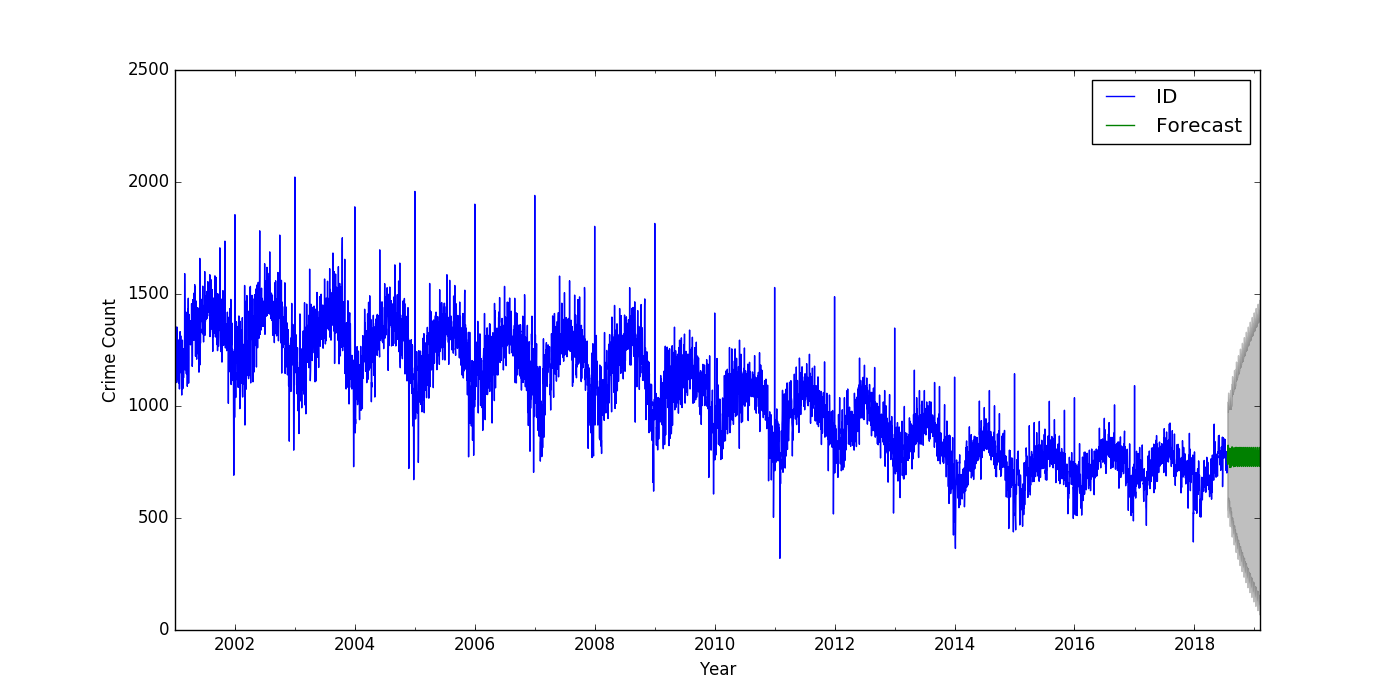

In [38]:
pred_uc = results.get_forecast(steps=200)
pred_ci = pred_uc.conf_int()
ax = crime_per_date.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Crime Count')
plt.legend()
plt.show()
display()